In [3]:
# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline


# Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier, plot_importance, plot_tree
from sklearn.metrics import classification_report, RocCurveDisplay

# Interpretability
from sklearn.inspection import PartialDependenceDisplay
import shap
shap.initjs()            # enable shap.force_plot()

# Set transformers output to Pandas DataFrame instead of NumPy array
from sklearn import set_config
set_config(transform_output="pandas")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Loading the data

In [4]:
df = pd.read_csv('/kaggle/input/loan-eligible-dataset/loan-train.csv')
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [5]:
df.drop('Loan_ID', axis=1, inplace=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             601 non-null    object 
 1   Married            611 non-null    object 
 2   Dependents         599 non-null    object 
 3   Education          614 non-null    object 
 4   Self_Employed      582 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         592 non-null    float64
 8   Loan_Amount_Term   600 non-null    float64
 9   Credit_History     564 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 57.7+ KB


In [7]:
df.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

## Separating numeric from categorical features

In [8]:
X = df.drop('Loan_Status', axis=1)
y = df['Loan_Status']

In [9]:
num_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
cat_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']

print(num_features)
print(cat_features)

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']


## Looking for outliers

In [10]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


<Figure size 1800x1200 with 0 Axes>

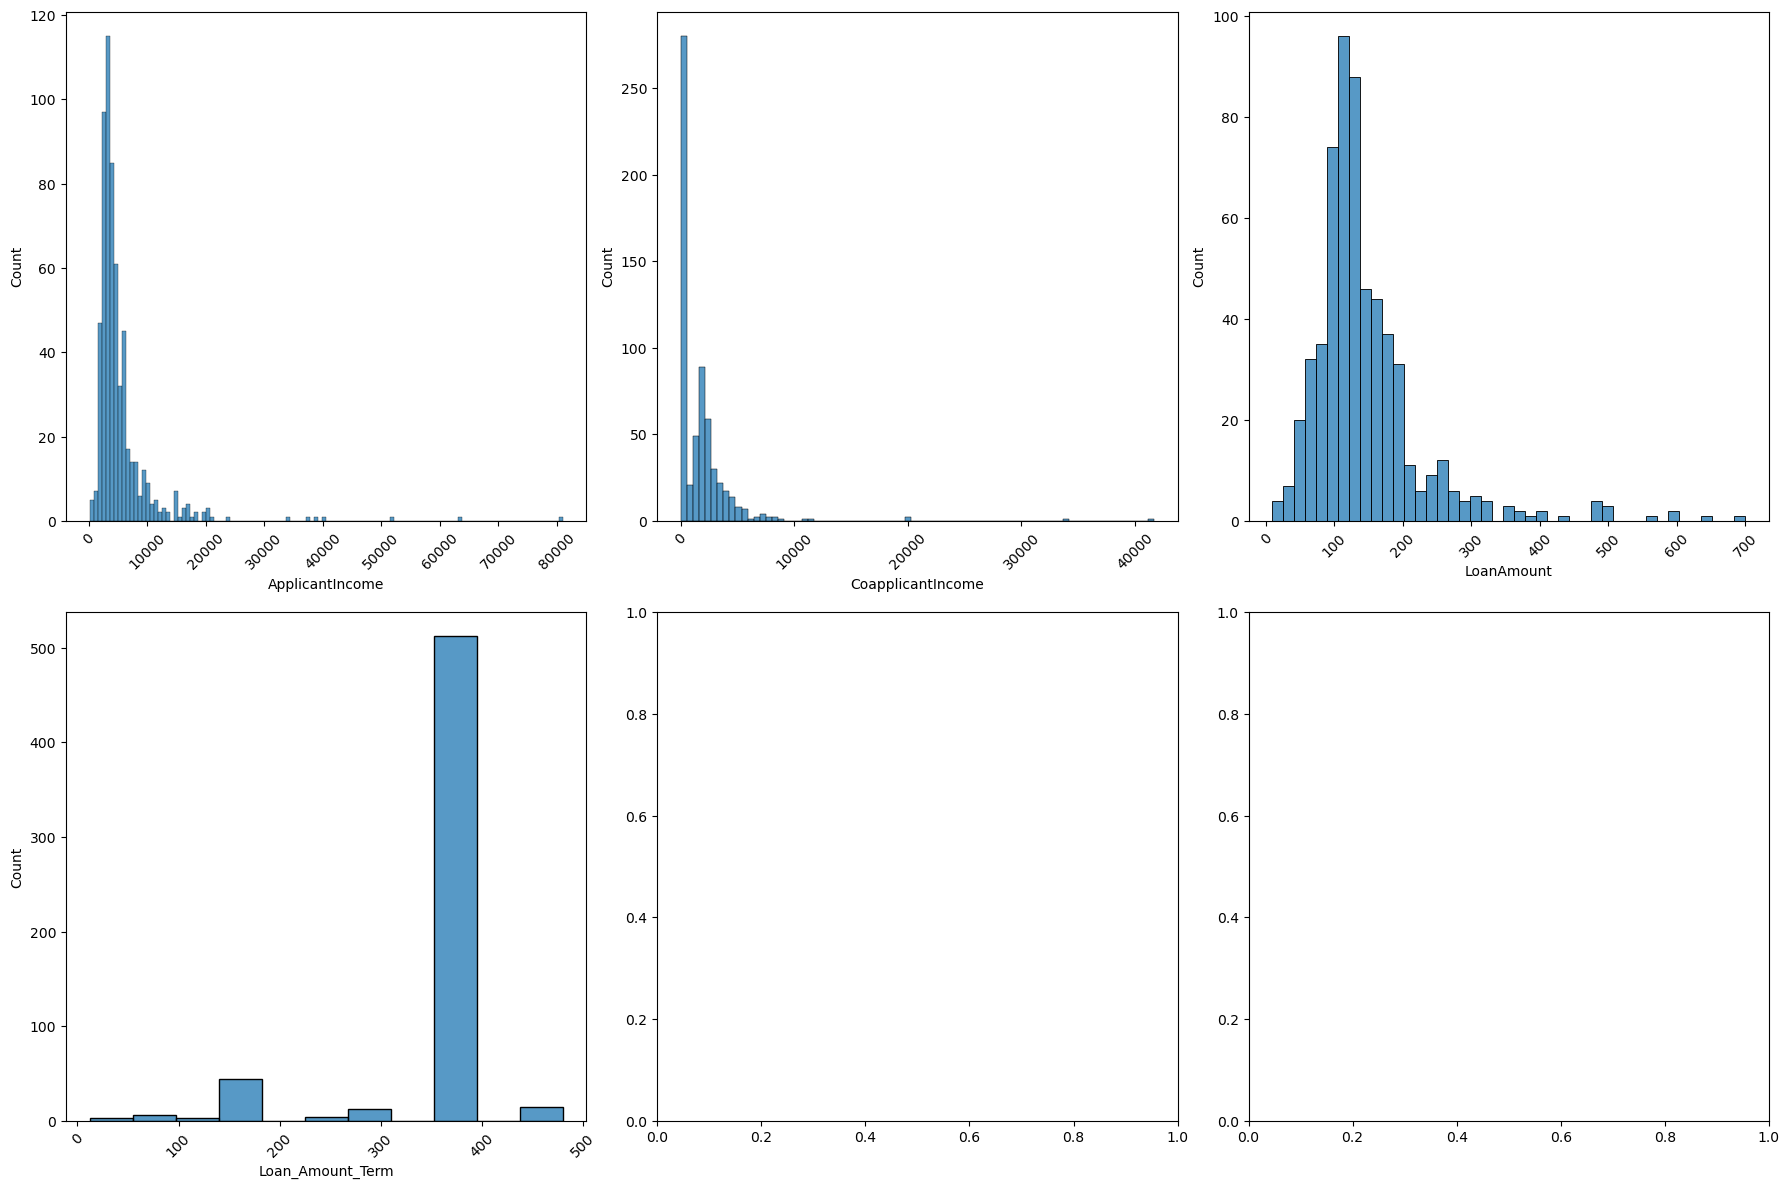

In [11]:
plt.figure(figsize=(18, 12))  # overall figure size
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # size of the subplots

axs = axs.flatten()

for i, col in enumerate(num_features):
    sns.histplot(df[col], ax=axs[i])
    axs[i].set_xlabel(col)  # Set x-axis label
    
    # Rotate x-axis labels if they are too long
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

<Figure size 1800x1200 with 0 Axes>

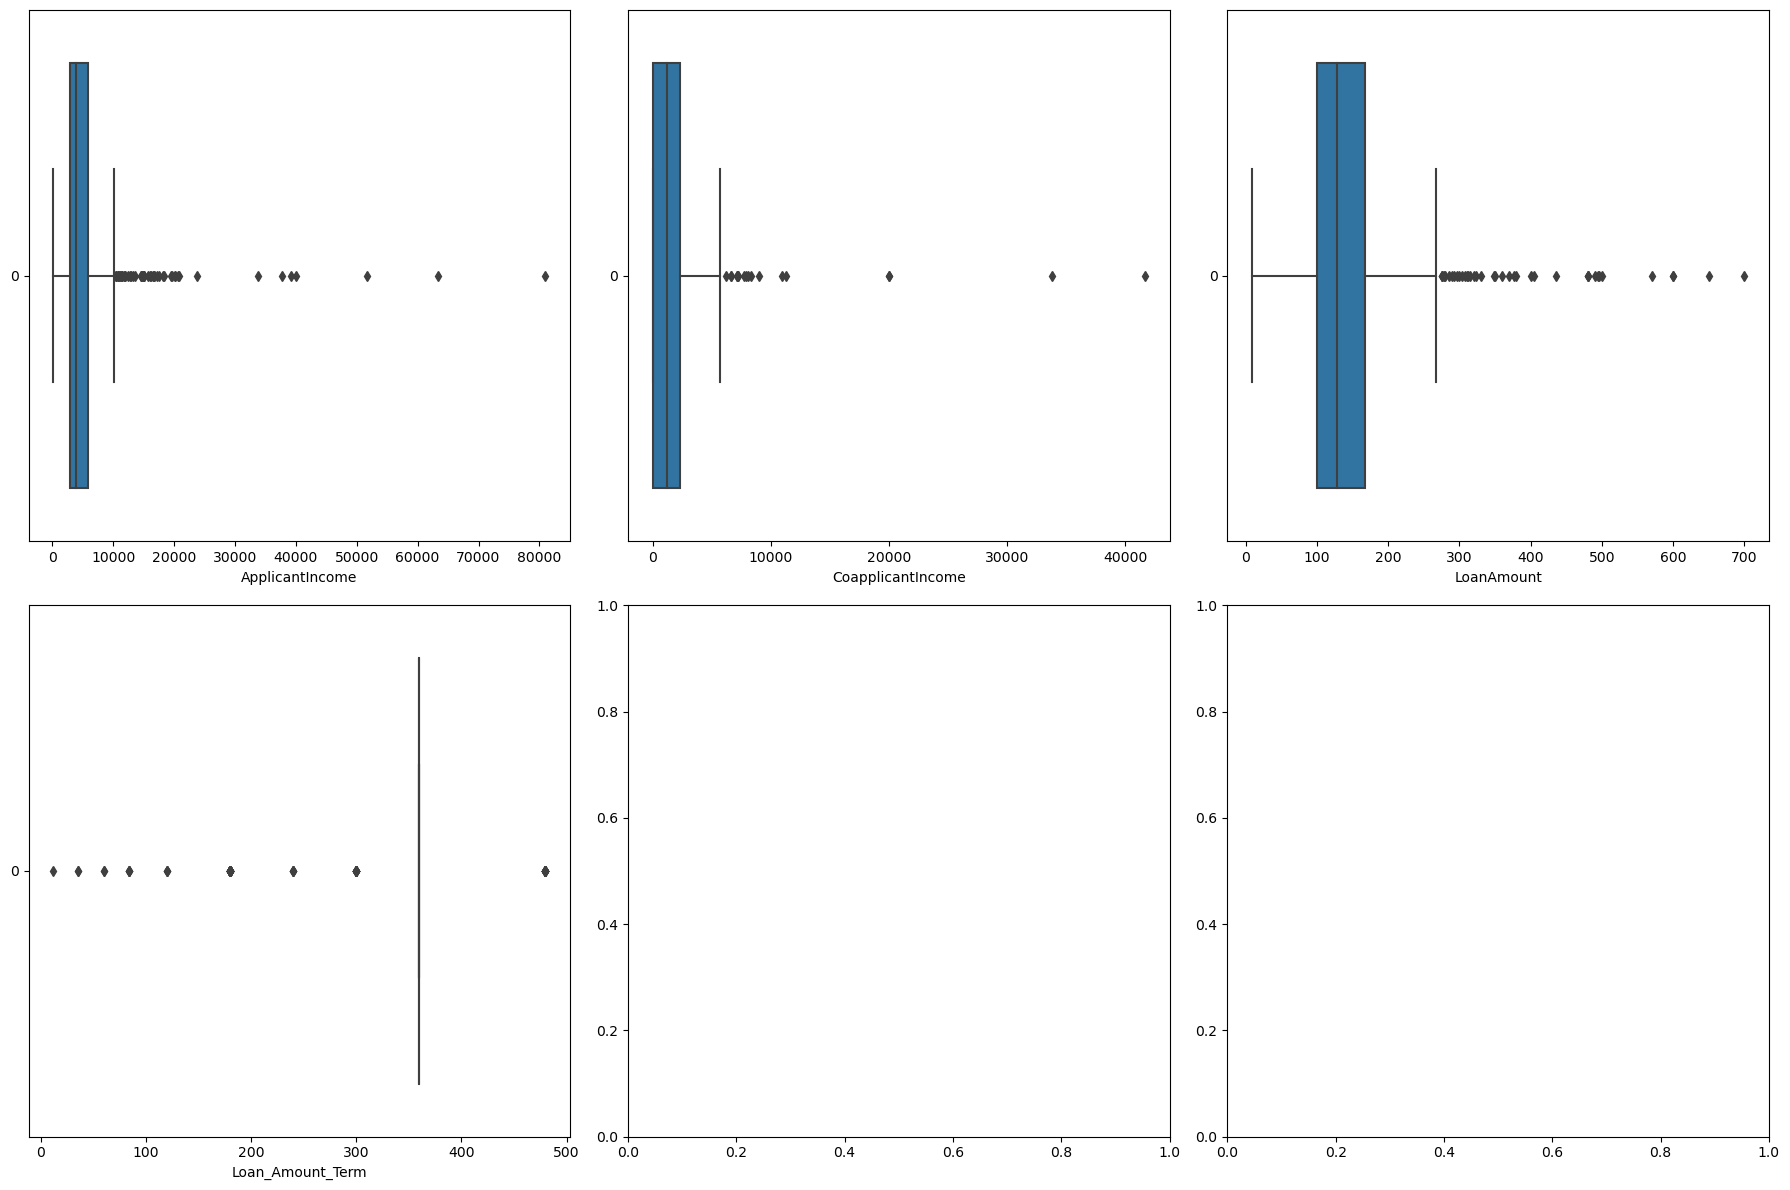

In [12]:

plt.figure(figsize=(18, 12))  # overall figure size
fig, axs = plt.subplots(2, 3, figsize=(18, 12))  # size of the subplots

axs = axs.flatten()

for i, col in enumerate(num_features):
    sns.boxplot(df[col], ax=axs[i], orient='h')
    axs[i].set_xlabel(col)  # Set x-axis label
    
    # Rotate x-axis labels if they are too long
    axs[i].tick_params(axis='x')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

## Checking for class imbalance
The data is not severly imbalanced.

Approved Loan Ratio 31%


Text(0.5, 1.0, 'Loan Status: Approved VS Rejected')

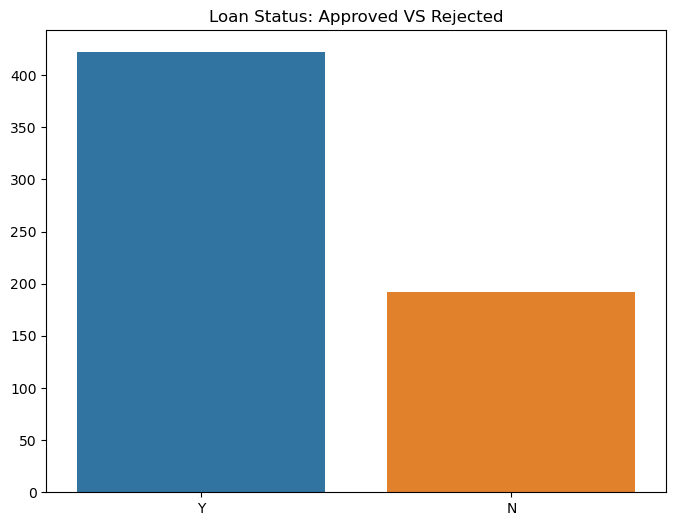

In [13]:
class_counts = y.value_counts()
print(f'Approved Loan Ratio {round(class_counts[1] / len(df) * 100)}%')

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Loan Status: Approved VS Rejected')

## Preprocessing

In [14]:
# Creating the preprocessing pipelines for both numeric and categorical data
numeric_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', PowerTransformer())
])

categoric_pipe = Pipeline([
    ( 'imputer', SimpleImputer(strategy='most_frequent') ),
    ( 'onehot', OneHotEncoder(drop='if_binary', sparse_output=False, handle_unknown='ignore') )
])

# Combining the preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ("numerical", numeric_pipe, num_features),
        ('categorical', categoric_pipe, cat_features),
    ], 
    remainder='passthrough',
    verbose_feature_names_out=False
)

**Encoding the target**

In [15]:
le = LabelEncoder()
y = le.fit_transform(y)

### Split into train and test set

In [16]:
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, stratify=y, test_size=0.2, random_state=42
)

## Training & Evaluation

### Training

In [17]:
classifier = LogisticRegression(class_weight='balanced')
classifier.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

### Evaluating the model

In [18]:
y_pred = classifier.predict(X_test)
report = classification_report(y_pred, y_test)
print(report)

              precision    recall  f1-score   support

           0       0.74      0.72      0.73        39
           1       0.87      0.88      0.88        84

    accuracy                           0.83       123
   macro avg       0.80      0.80      0.80       123
weighted avg       0.83      0.83      0.83       123



Text(0.5, 1.0, 'ROC Curve')

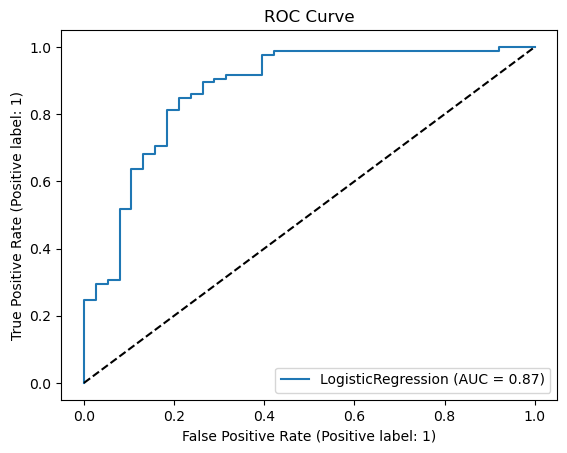

In [19]:
RocCurveDisplay.from_estimator(classifier, X_test, y_test)
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.title('ROC Curve')

So far, no coefficient seems to be exaggerated.
The credit history has the most important on the model's predictions. Indeed, no credit history means rejection is guaranteed. 

In [20]:
coef_df = pd.DataFrame(classifier.coef_[0], classifier.feature_names_in_)
coef_df.sort_values(by=0, ascending=False)

,0
Credit_History_1.0,3.081547
Property_Area_Semiurban,0.461820
Married_Yes,0.450716
Dependents_2,0.337570
CoapplicantIncome,0.182194
ApplicantIncome,0.108393
Dependents_3+,0.065514
Dependents_0,-0.021273
Loan_Amount_Term,-0.082197
Self_Employed_Yes,-0.137888


## Explaining the model with SHAP

How does the model learn?
Let's open the box.

### Mapping the Data to its Original Scale

The data was scaled to train the model but we want to visualize the explanations with the original values.

Based on the property that *any univariate transformation applied to a model’s inputs does not effect the Shapley values for the model*, we can replace the scaled value in the model explainer by the original values.

See [shap documentation](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/linear_models/Explaining%20a%20model%20that%20uses%20standardized%20features.html).

In [21]:
# Get the scaler and encoder object from the pipeline
scaler = preprocessor.named_transformers_['numerical']['scaler']
encoder = preprocessor.named_transformers_['categorical']['onehot']

# Unscaled the  data 
X_test_num_unscaled = scaler.inverse_transform(X_test[scaler.feature_names_in_])
X_test_num_unscaled_df = pd.DataFrame(data=X_test_num_unscaled, columns=scaler.feature_names_in_)

# Get the one-hot encoded features
X_test_cat = X_test[encoder.get_feature_names_out()]

# Reset the index before concatenation
X_test_num_unscaled_df.reset_index(drop=True, inplace=True)
X_test_cat.reset_index(drop=True, inplace=True)

# Concat the unscaled numeric data and the categorical data
X_test_unscaled = pd.concat([X_test_num_unscaled_df, X_test_cat], axis=1)
X_test_unscaled.head()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Gender_Male,Married_Yes,Dependents_0,Dependents_1,Dependents_2,Dependents_3+,Education_Not Graduate,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban,Credit_History_1.0
0,6277.0,0.0,118.0,360.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,4180.0,2306.0,182.0,360.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,9963.0,0.0,180.0,360.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
3,5500.0,1260.0,170.0,360.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,2330.0,4486.0,100.0,360.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


### Creating a shap explainer

In [22]:
explainer = shap.LinearExplainer(classifier, X_test)
shap_explanation = explainer(X_test)

# Replace the scaled values by the original ones
shap_explanation.data = X_test_unscaled.values

In [23]:
edero

NameError: name 'edero' is not defined

### Explain Global Predictions

How does the model make predictions overall?

This plot below is simple yet powerful. Here is how to interpret it:

#### Blue VS Red

- Colors close to red indicate high values
- Colors close to blue indicate small values

#### Approval VS Rejection

On the X-axis are the SHAP values separated at 0 by a vertical line. SHAP values greater than 0 push the prediction towards the positive class (approval), while the one lower than 0 push the prediction towards the negative class (rejection):

- Points on the left of the vertical line have SHAP values lower than 0. They negatively impact approval (positive class)
- Points on the right of the vertical line have SHAP values greater than 0. They postively impact the approval.


In other words, if a point is after the vertical line, it moves the prediction towards the positive class (Approval).
If this point is blue, it indicates that its value is low. 

Look at the plot below, in the case of "Loan amount", we can observe that higher values move the prediction towards the negative class (rejection). In fact, the higher the loan amount, the less likely it is to be approved.
It is good to see that the Gender has no effect on the prediction.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


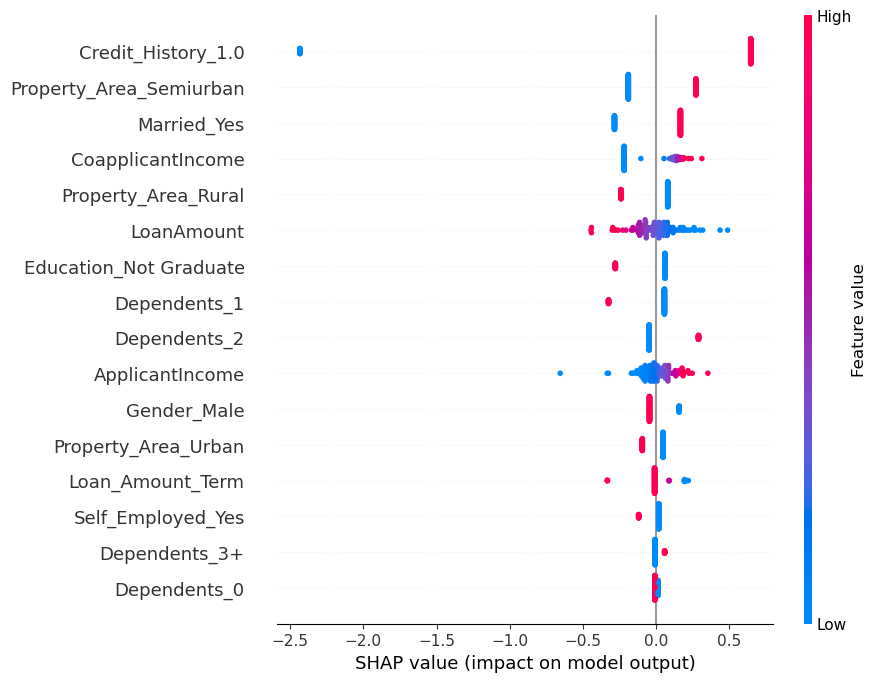

In [24]:
shap.plots.beeswarm(shap_explanation, max_display=100)

#### Explaining numeric features

It is counterintuitive to see that higher the co-applicant income leads to lower probability of being approved. 

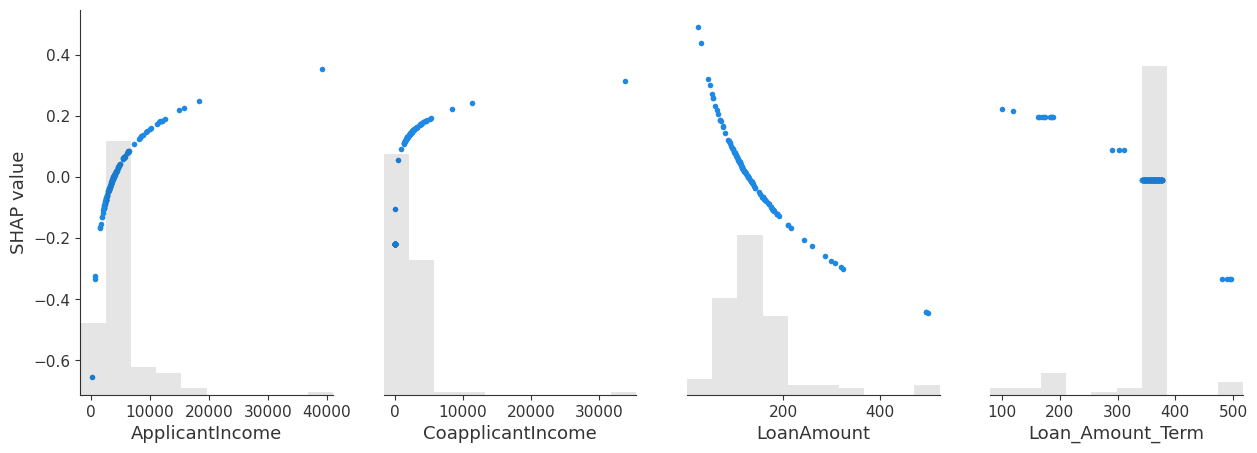

In [25]:
shap.plots.scatter(shap_explanation[:, 0:4])

### Explaining a single prediction

The first applicant in the test data has been rejected, let's investigate why. 

The applicant has no credit history. This alone makes them ineligible for a loan application. 

In [26]:
print('Approved' if y_test[0]==1 else 'Rejected')

Rejected


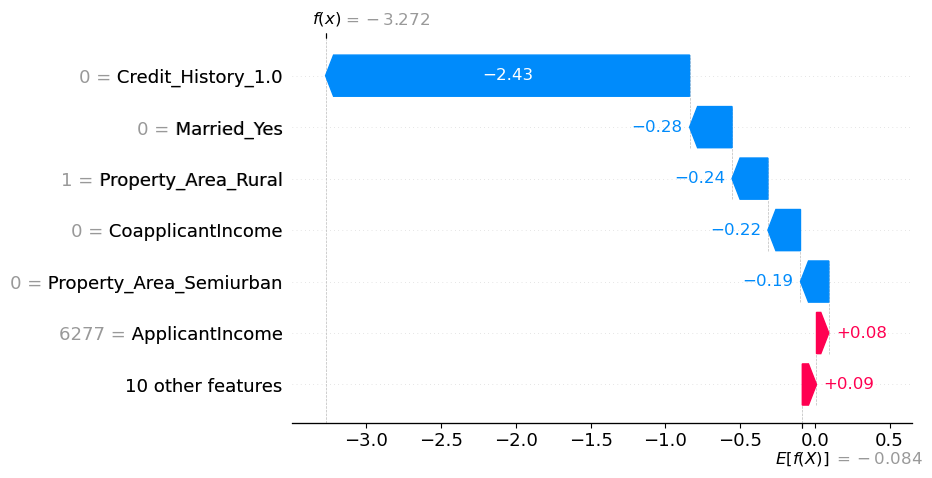

In [27]:
shap.plots.waterfall(shap_explanation[0], max_display=7)

In [28]:
shap.force_plot(shap_explanation[0])

## Explaining the model with Partial Dependence and ICE

In [29]:
def plot_dependence(features, shap_values, data, plot_shape, figsize=(16, 4)):
    ## Using SHAP functions
    _, axs = plt.subplots(ncols=plot_shape[0], nrows=plot_shape[1], figsize=figsize, constrained_layout=True)
    axs = axs.flatten()

    for i, feature in enumerate(num_features):
        shap.dependence_plot(feature, shap_values, X_test, ax=axs[i], show=False)

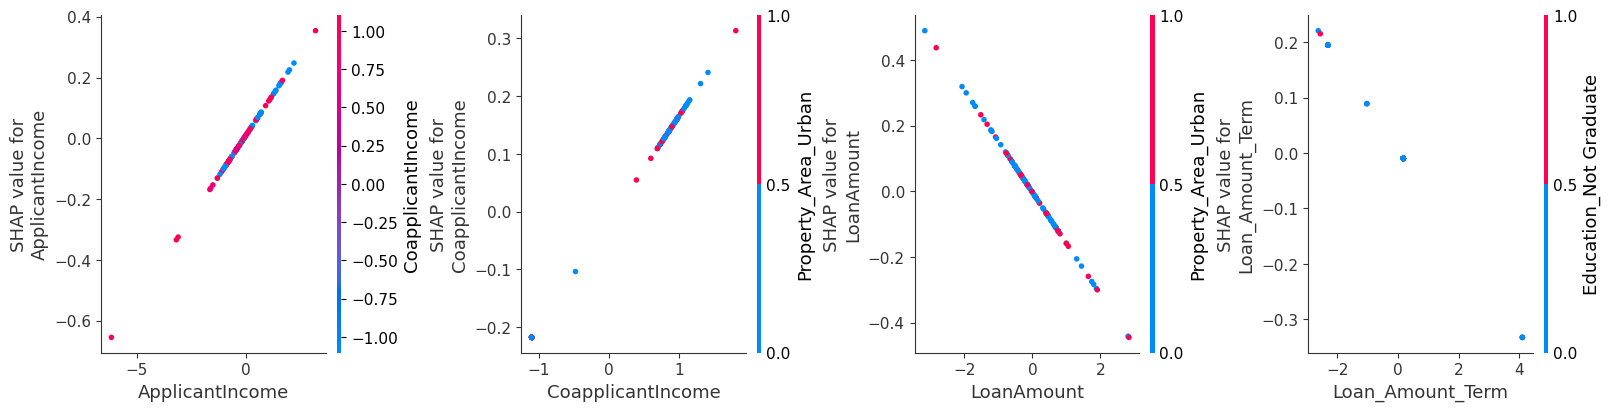

In [30]:
plot_dependence(features=num_features, shap_values=shap_explanation.values, data=X_test, plot_shape=(4, 1), figsize=(16, 4))

### Partial Dependance

In [31]:
def pdp_plot(data, features, plot_shape, figsize=(12, 9), cat_features=None):
    """
    Create a Partial Dependence Plot (PDP) of the specified features.

    Parameters
    ----------
    data : array-like or pd.DataFrame
        The dataset for which to create the PDP.
    features : list of str
        List of feature names for which to create the PDP.
    plot_shape : tuple
        A tuple specifying the shape (columns, rows) of the subplot grid.
    figsize : tuple
        A tuple specifying the size (width, height) of the figure.
     cat_features : list of str, default=None
        List of categorical feature names.
    Notes
    -----
    - `cat_features parameter indicates the categorical features in the data.
    It is useful to plot bars instead of line plots for categories.
    """
    # Define feature information for PartialDependenceDisplay
    features_info = {
        "features": features,
        "kind": "average",
        "categorical_features": cat_features,
    }

    # Create a subplot grid for PDP plots
    _, ax = plt.subplots(ncols=plot_shape[0], nrows=plot_shape[1], figsize=figsize, constrained_layout=True)

    # Get the PartialDependenceDisplay object
    display = PartialDependenceDisplay.from_estimator(
        classifier,  # Specify your classifier here
        data, 
        **features_info, 
        ax=ax,
    )

    # Set the title for the entire figure
    display.figure_.suptitle("Partial dependence of Loan Eligibility", fontsize=16)


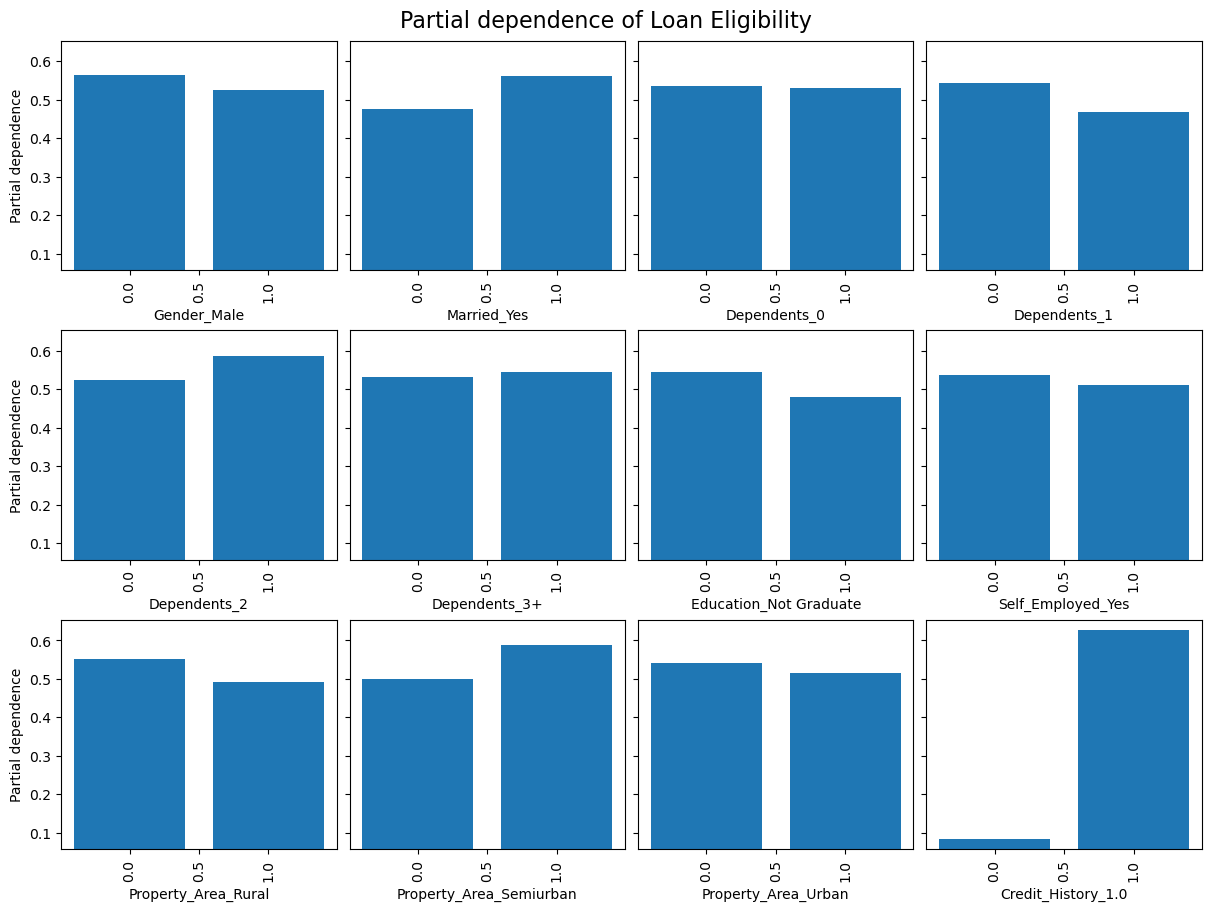

In [32]:
cat_features_encoded = encoder.get_feature_names_out()
pdp_plot(data=X_test, features=cat_features_encoded, cat_features=cat_features_encoded,
         plot_shape=(4, 3), figsize=(12, 9))

### Individual Conditional Expectation

We observe that the greater the loan amount, the less likely it is to be approved. Same for the co-applicant income. It seems that the model thinks that if the co-applicant has a high income, the loan should not be approved.

In [33]:
def ice_plot(data, features, plot_shape, figsize=(12, 4)):
    """
    Create an Individual Conditional Exceptectation (ICE) Plot of the specified features.

    Parameters
    ----------
    data : array-like or pd.DataFrame
        The dataset for which to create the PDP.
    features : list of str
        List of feature names for which to create the PDP.
    plot_shape : tuple
        A tuple specifying the shape (columns, rows) of the subplot grid.
    figsize : tuple
        A tuple specifying the size (width, height) of the figure.
    """
    features_info = {
        "features": features, 
        "kind": "both",
    }

    _, ax = plt.subplots(ncols=plot_shape[0], nrows=plot_shape[1], figsize=figsize, constrained_layout=True)

    display = PartialDependenceDisplay.from_estimator(
        classifier, data, **features_info, ax=ax,
    )

    display.figure_.suptitle("PDP and ICE of Loan ELigibility", fontsize=16)

In [34]:
# ice_plot(X_test_unscaled, num_features, plot_shape=(2, 2), figsize=(7, 6))

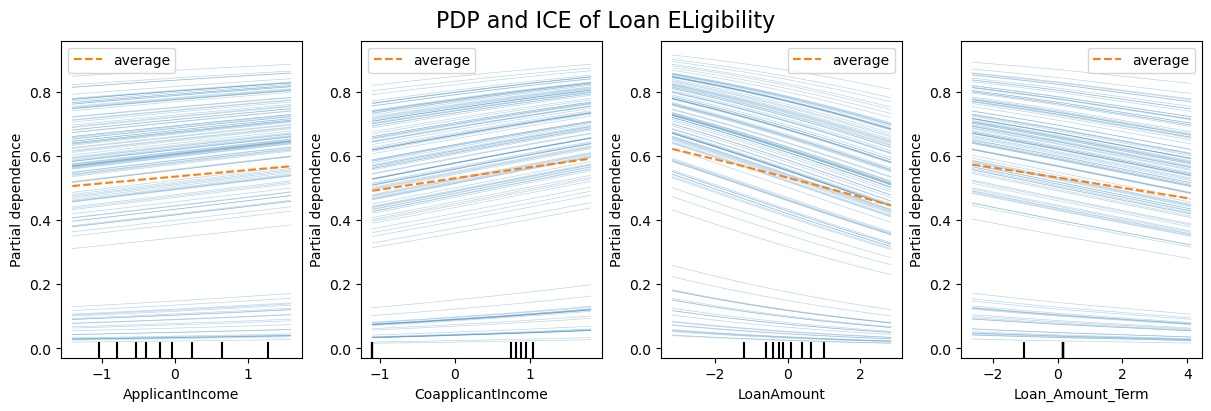

In [35]:
ice_plot(data=X_test, features=num_features, plot_shape=(4, 1), figsize=(12, 4))

#### Conclusion

From the summary plot and the partial dependence plot, we can conclude that:

Higher applicant income increases the probability of being approved. The tendency is inverted for the co-applicant income.
A high loan amount decreases the probability of being approved. The same applies to the loan amount term.

### Feature Interaction

In [34]:
feature_pair1 = (features[0], features[1])
feature_pair2 = (features[1], features[2])
feature_pair3 = (features[0], features[2])
feature_pairs = [feature_pair1, feature_pair2, feature_pair3]

pdp_plot(data=X_test, features=feature_pairs, plot_shape=(3, 1), figsize=(12, 4))

NameError: name 'features' is not defined